<a href="https://colab.research.google.com/github/Pau993/Taller08RAG/blob/main/Taller08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparación previa al laboratorio:**

# **2. Guía paso a paso para construir un RAG:**

In [246]:
!pip install -qU "langchain[openai]"

In [247]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [248]:
!pip install -qU langchain-openai

In [249]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

# **Preview**

In [250]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [251]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition is the process of breaking down a complex task into smaller, manageable steps or subgoals. This can be achieved through prompting techniques like "Chain of Thought" (CoT) or by using task-specific instructions. It helps clarify the reasoning process of models by allowing them to tackle each component systematically.


# **Detailed walkthrough**

In [252]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


In [253]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


# **Splitting documents**

In [254]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


## Storing documents

In [255]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['6971fb38-f465-452b-90e6-0a7ed1ce8bde', 'de34433a-3936-43b1-a7f1-14390eec722a', 'ee93b4c6-189d-4737-8c62-3c52f9a65929']


## **2. Retrieval and Generation**

In [256]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Para usar LangGraph, necesitamos definir tres cosas:

1. El estado de nuestra aplicación;
2. Los nodos de nuestra aplicación;
3. El flujo de control de nuestra aplicación.

In [257]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

nodes:

In [258]:
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Control flow

In [259]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

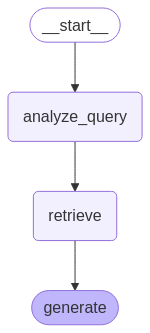

In [260]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# **Usage**

Invoke

In [262]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: []


Answer: Task decomposition is the process of breaking down a complex task into smaller, more manageable subtasks. This approach promotes better organization, enhances focus, and improves efficiency in completing the overall task. It is commonly used in areas such as project management, software development, and artificial intelligence.


In [263]:
print(type(graph))


<class 'langgraph.graph.state.CompiledStateGraph'>


In [264]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'What is Task Decomposition?', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': []}}

----------------

{'generate': {'answer': 'Task decomposition is the process of breaking down a complex task into smaller, more manageable sub-tasks. This approach allows individuals or systems to tackle each part systematically, making it easier to achieve the overall goal. It is commonly used in various fields, including project management and artificial intelligence.'}}

----------------



In [265]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|{"|query|":"|What| is| Task| De|composition|?|","|section|":"|begin|ning|"}|||||Task| decomposition| is| the| process| of| breaking| down| a| complex| task| into| smaller|,| more| manageable| components| or| subt|asks|.| This| approach| simplifies| problem|-solving| and| can| enhance| efficiency| by| allowing| teams| or| individuals| to| focus| on| one| aspect| at| a| time|.| It| is| commonly| used| in| project| management|,| software| development|,| and| various| fields| requiring| organized| workflow|.||

### Personalización de la solicitud

In [266]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

# **Análisis de consultas**

In [267]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [268]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [269]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

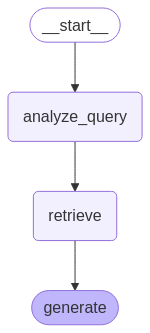

In [270]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [271]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='cf162eb9-9a0d-4bbb-a8d4-1b4b6de936cf', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 33070, 'section': 'end'}, page_content='You will get instructions for code to write.\nYou will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.\nMake sure that every detail of the architecture is, in the end, implemented as code.\nThink step by step and reason yourself to the right decisions to make sure we get it right.\nYou will first lay out the names of the core classes, functions, methods that will be necessary, as well as a quick comment on their purpose.\nThen you will output the content of each file including ALL code.\nEach file must strictly follow a markdown code block format, where the following tokens must be replaced such that\nFILENAME is the lowe

# **3. Implementación y Entregables:**

In [272]:
!pip install -U langchain-openai pinecone-client langchain

In [275]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "El sistema de recomendación de películas utiliza un modelo de aprendizaje automático.",
     "question": "¿Cómo funciona un sistema de recomendación de películas?"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": "Un sistema de recomendación de películas utiliza algoritmos que analizan el historial de visualización y preferencias del usuario para sugerir contenido relevante."}


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: ¿Cómo funciona un sistema de recomendación de películas? 
Context: El sistema de recomendación de películas utiliza un modelo de aprendizaje automático. 
Answer:


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
